In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join, basename,exists
from glob import glob
from tqdm import tqdm
import pytz
from operator import itemgetter

from infrasound import prep, mseed2arr, prep_wx, daily_power, daily_hour_power, slice_power, get_day, strf_date, dB_convert, get_hour, correlation_plot, freq_filt

from obspy import read
from scipy.signal import correlate, correlation_lags, butter, filtfilt, spectrogram
from scipy.stats import pearsonr
from numpy.fft import fft, fftfreq, ifft, fftshift
import statsmodels.api as sm

In [8]:
ac_calib = 8.2928e-05

in_dir = '/home/zacharykeskinen/data/infrasound/infrasound/processed' #infrasound/banner/infrasound/processed/'
in_dir = '../../../data/banner/infrasound/processed'
exists(in_dir)

# l = os.listdir(in_dir)
l = glob(os.path.join(in_dir, 'c0be4*'))
r = []
for i in l:
    i = os.path.basename(i)
    j = i[5:11]
    if j not in r:
        r.append(j)
r.sort()
print(len(r))

116


In [9]:
def show_eq_all_heights(day_list, eq_day, eq_hour, start_min, end_min, fc_low = 5, fc_high = None, sps = 200, in_dir = in_dir, title = None, ylims = None):
    res = get_day(day_list, eq_day, in_dir)
    if pd.to_datetime(eq_day, format='%y%m%d') < pd.to_datetime('2022-01-22'):
        heights = [0.33,0.66,1]
    else:
        heights = [1.33,1,0.66,0.33]
    f, ax = plt.subplots(len(heights), figsize = (18,12))
    for i, height in enumerate(heights):
        if fc_high:
            res_hourly_1 = freq_filt(res[height], 2, fc_high, 'low')
        if fc_low:
            res_hourly_1 = freq_filt(res[height], 2, fc_low, 'high') 

            res_hourly_1 = res_hourly_1.reshape(24, -1)[eq_hour]
            start = int(start_min*60*sps)
            end = int(end_min*60*sps)
            arr1 = res_hourly_1[start:end]
            t = np.linspace(start_min, end_min, arr1.size)
            ax[i].plot(t, arr1)
            if not title:
                ax[0].set_title(f'{eq_day} - Array at {height_1} and {height_2} m')
            else:
                ax[0].set_title(title)
            ax[-1].set_xlabel('minutes')
            ax[i].set_ylabel(f'{height} m')
            if ylims:
                ax[i].set_ylim(ylims)

## Earthquakes

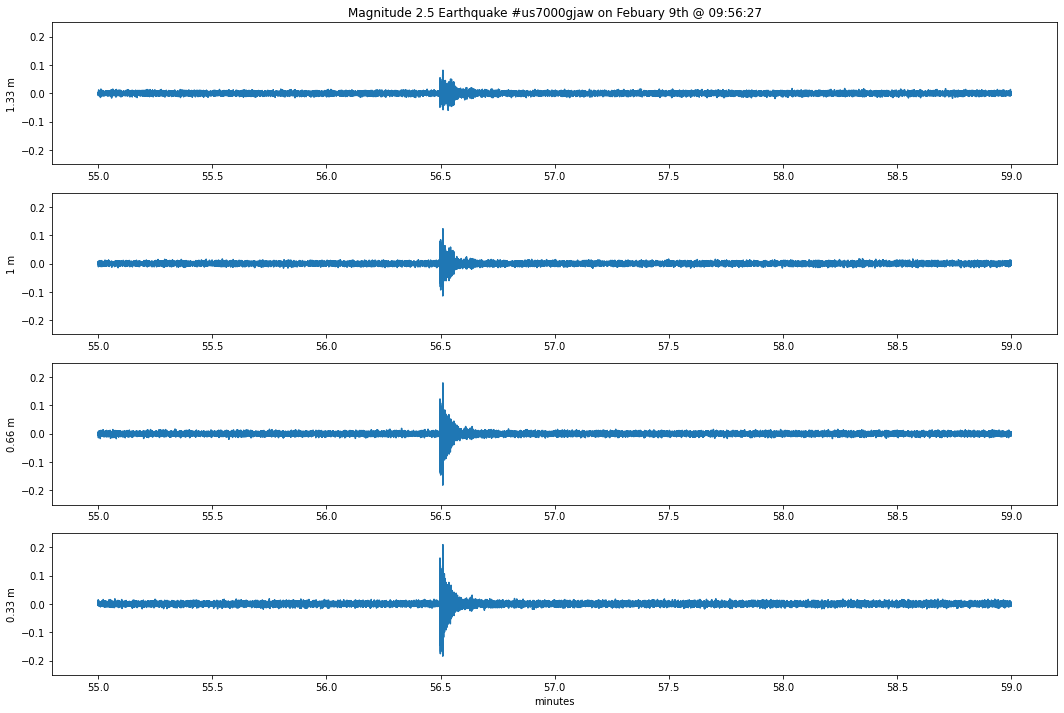

In [10]:
show_eq_all_heights(day_list = r, eq_day = '220209', eq_hour = 9, start_min = 55, end_min = 59, fc_low = 2, title= 'Magnitude 2.5 Earthquake #us7000gjaw on Febuary 9th @ 09:56:27', ylims=(-0.25,0.25))

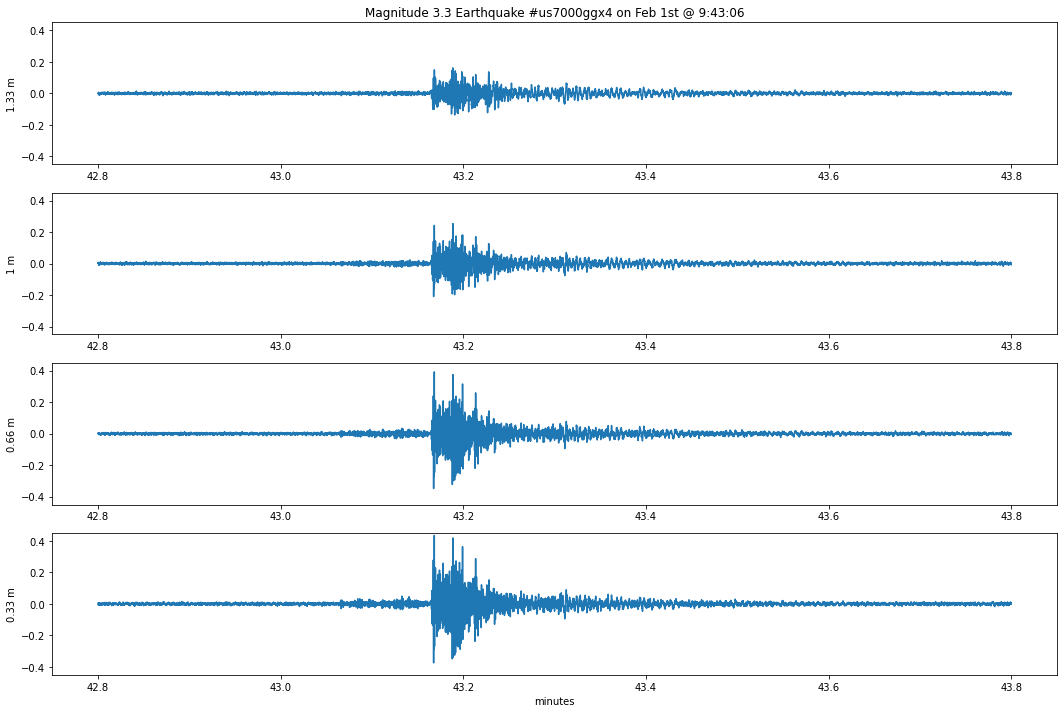

In [15]:
## https://earthquake.usgs.gov/earthquakes/eventpage/us7000gjaw/executive '2022-02-09 @ 09:56:27 - 
show_eq_all_heights(r, '220201', 9, 42.8, 43.8, fc_low = 2, title= 'Magnitude 3.3 Earthquake #us7000ggx4 on Feb 1st @ 9:43:06', ylims=(-0.45,0.45))

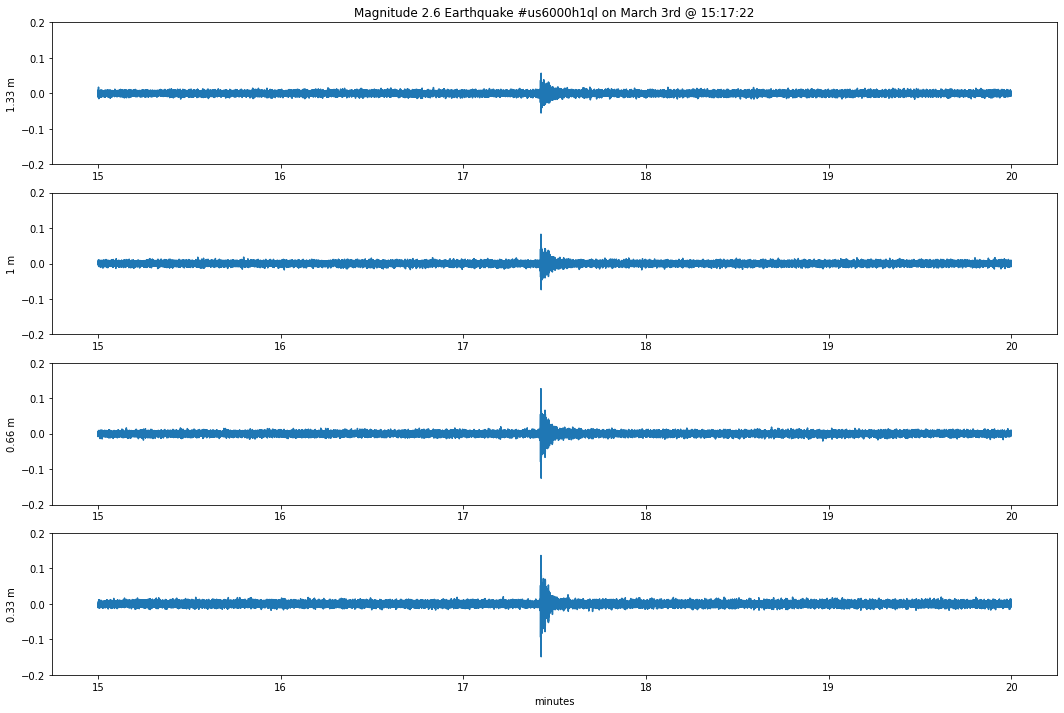

In [32]:
## https://earthquake.usgs.gov/earthquakes/eventpage/us6000h1ql/executive '2022-03-03 @ 15:17:22 - 
show_eq_all_heights(r, '220303', 15, 15, 20, fc_low = 2, title= 'Magnitude 2.6 Earthquake #us6000h1ql on March 3rd @ 15:17:22', ylims=(-0.2,0.2))

In [55]:
eq_plot_dic = {1: {'eq_day' : '220209', 'eq_hour': 9, 'start_min' : 56 , 'end_min' : 57, 'title' : 'M 2.5 Earthquake on Febuary 9th', 'ylims' : (-0.25,0.25)},
2: {'eq_day' : '220303', 'eq_hour': 15, 'start_min' : 17 , 'end_min' : 18, 'title' : 'M 2.6 Earthquake on March 3rd', 'ylims' : (-0.2,0.2)},
0: {'eq_day' : '220201', 'eq_hour': 9, 'start_min' : 42.8 , 'end_min' : 43.8, 'title' : 'M 3.3 Earthquake on Feb 1st', 'ylims' : (-0.45,0.45)}
}

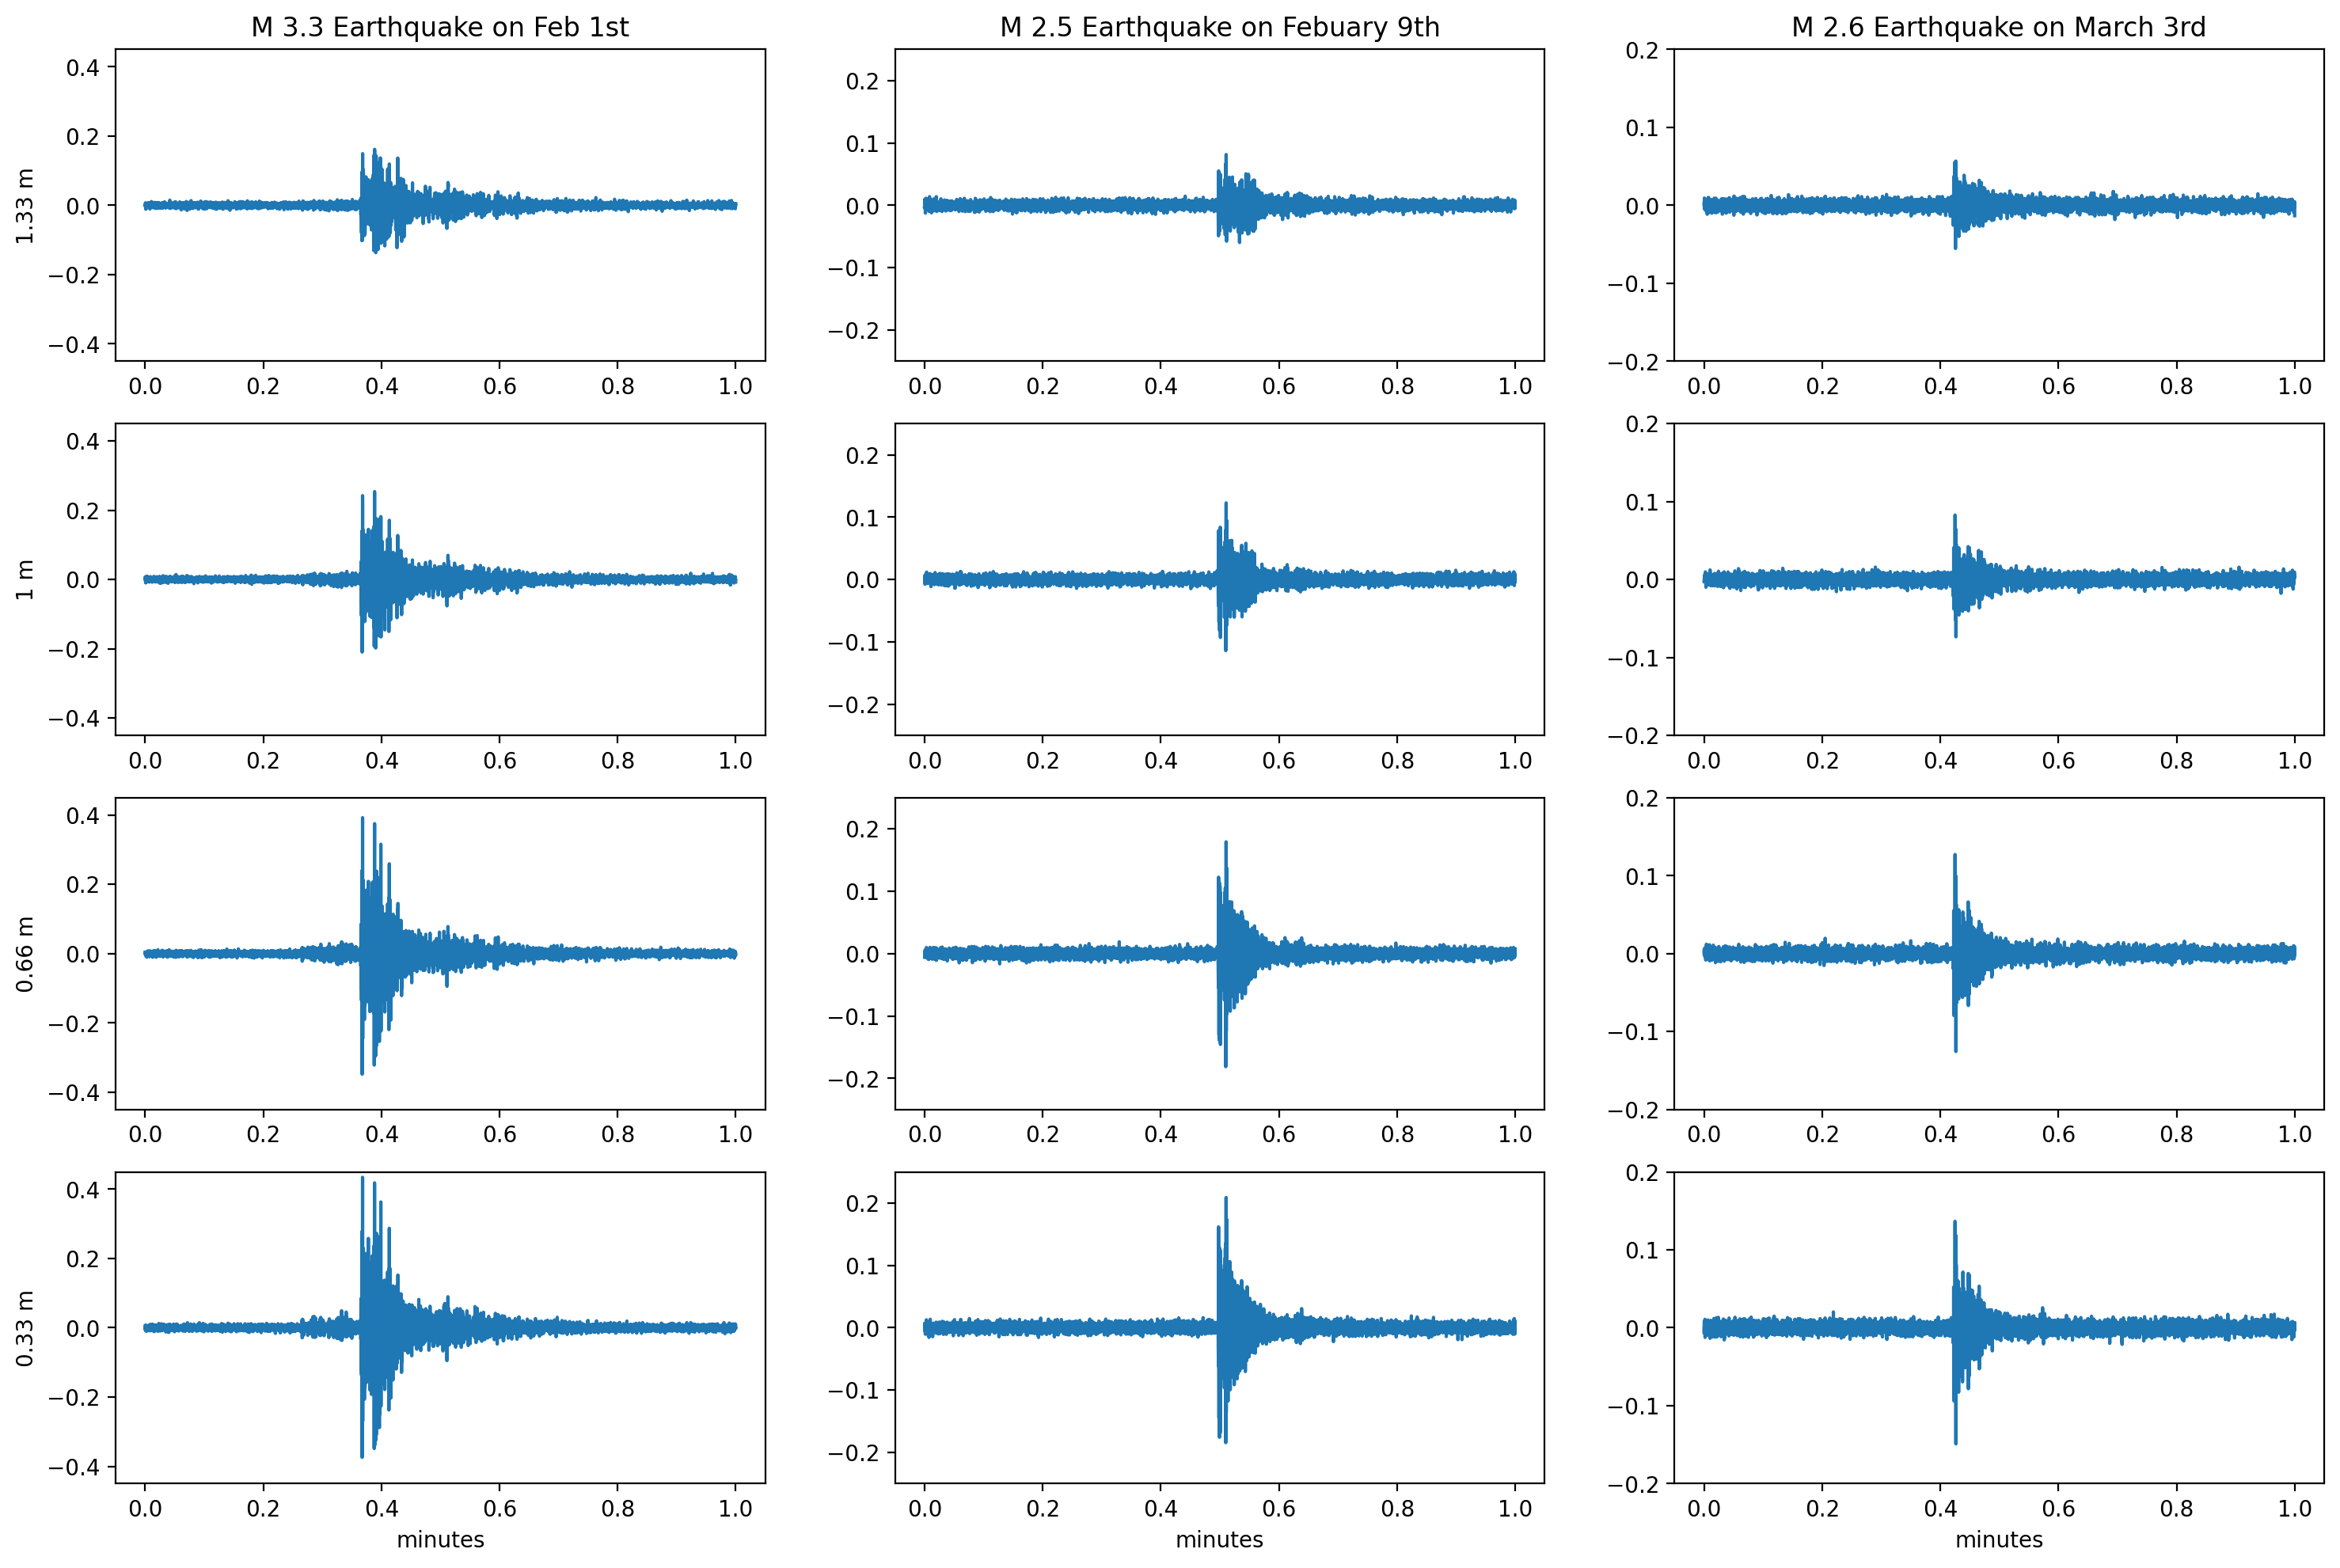

In [56]:
day_list = r
fc_low = 2
fc_high = None
sps = 200

f, ax = plt.subplots(4, 3, figsize = (18,12), dpi = 200)


for j, ann in eq_plot_dic.items():
    eq_day, eq_hour, start_min, end_min, title, ylims = itemgetter('eq_day','eq_hour','start_min','end_min','title','ylims')(ann)
    res = get_day(day_list, eq_day, in_dir)
    if pd.to_datetime(eq_day, format='%y%m%d') < pd.to_datetime('2022-01-22'):
        heights = [0.33,0.66,1]
    else:
        heights = [1.33,1,0.66,0.33]
    for i, height in enumerate(heights):
        p_ax = ax[i, j]
        if fc_high:
            res_hourly_1 = freq_filt(res[height], 2, fc_high, 'low')
        if fc_low:
            res_hourly_1 = freq_filt(res[height], 2, fc_low, 'high') 

            res_hourly_1 = res_hourly_1.reshape(24, -1)[eq_hour]
            start = int(start_min*60*sps)
            end = int(end_min*60*sps)
            arr1 = res_hourly_1[start:end]
            # t = np.linspace(start_min, end_min, arr1.size)
            t = np.linspace(0, end_min - start_min, arr1.size)
            p_ax.plot(t, arr1)
            ax[0, j].set_title(title)
            ax[-1, j].set_xlabel('minutes')
            if j == 0:
                p_ax.set_ylabel(f'{height} m')
            if ylims:
                p_ax.set_ylim(ylims)
plt.savefig(join('/home/zacharykeskinen/Documents/infrasound/figures/signal_compares','all_eqs.png'))

## Avalanche

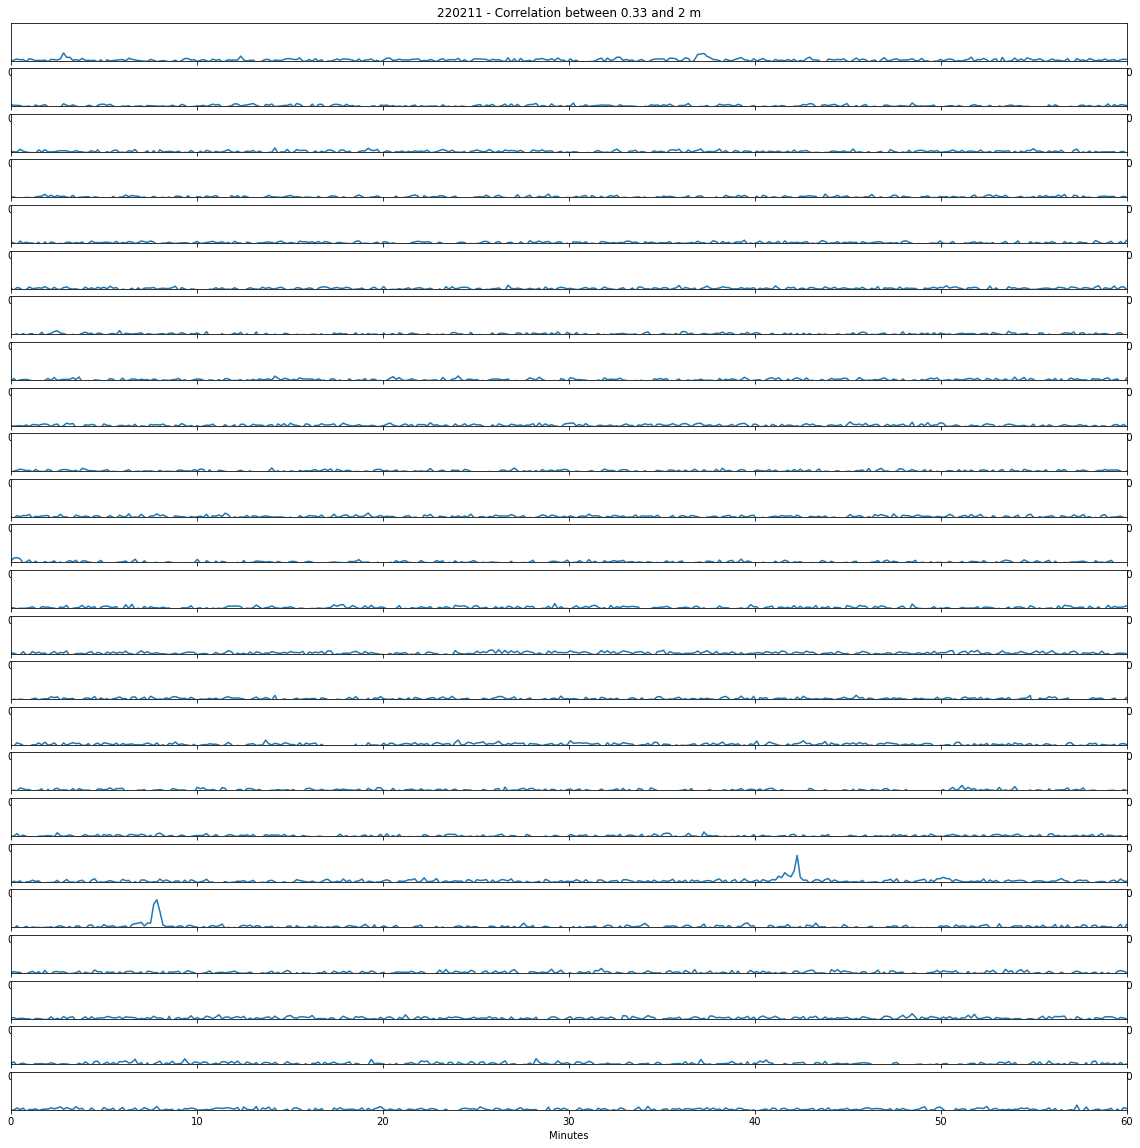

In [31]:
correlation_plot(r, '220211', 0.33, 2, fc = 5, wind_len_sec = 10, in_dir = in_dir)

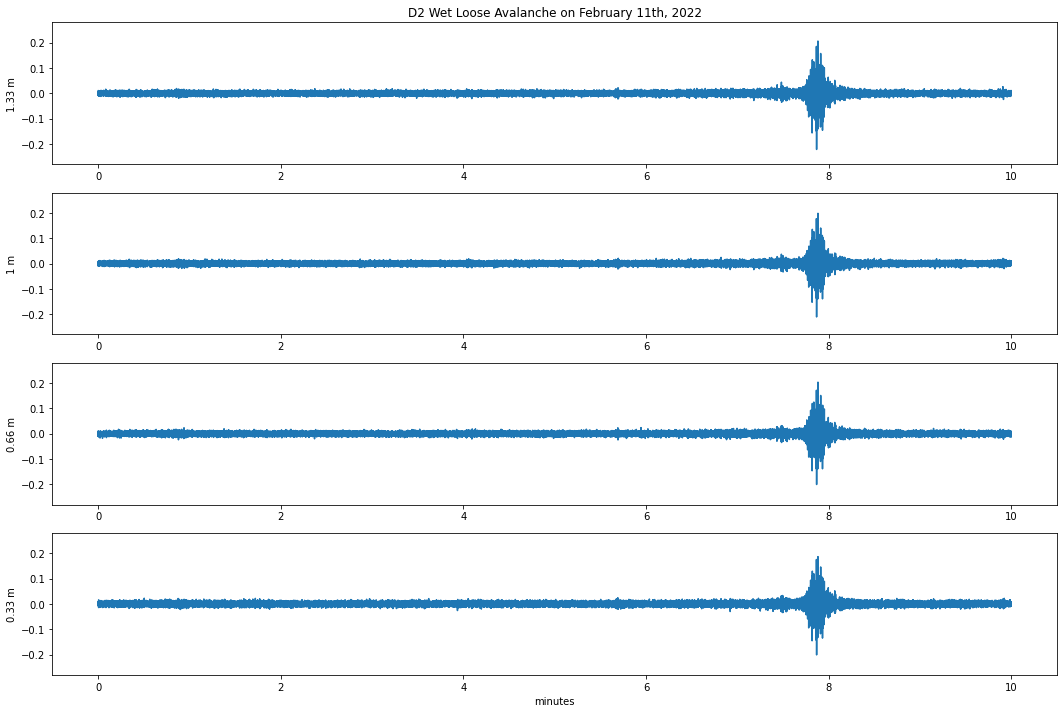

In [25]:
show_eq_all_heights(day_list = r, eq_day = '220211', eq_hour = 19, start_min = 0, end_min = 10, fc_low = 2, title= 'D2 Wet Loose Avalanche on February 11th, 2022', ylims=(-0.28,0.28))

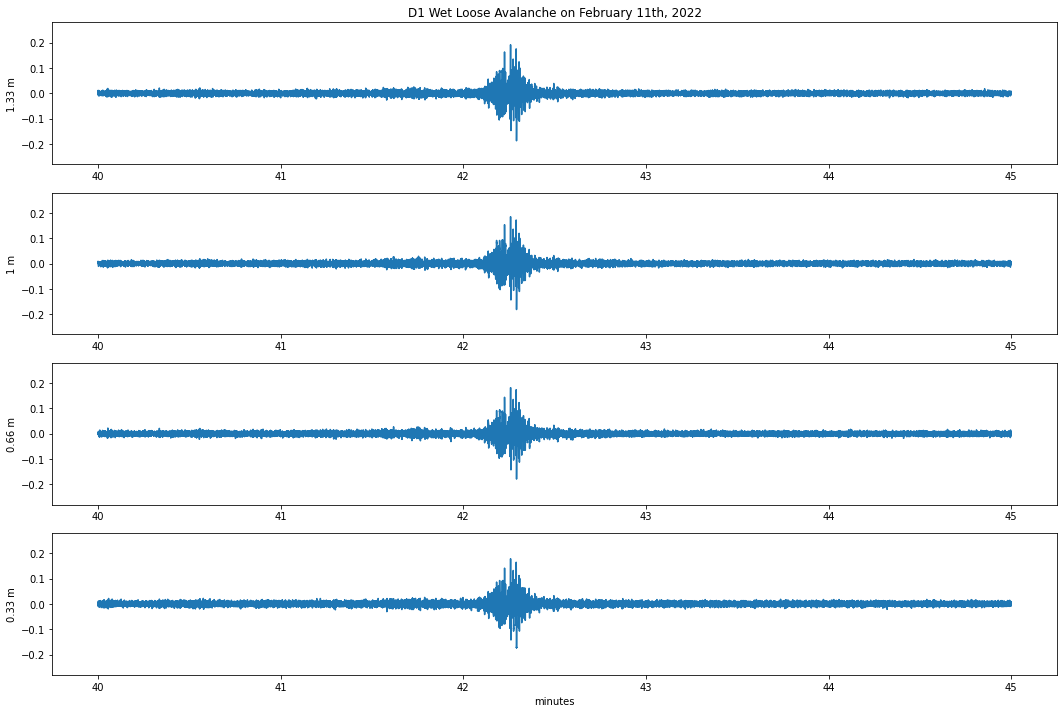

In [27]:
show_eq_all_heights(day_list = r, eq_day = '220211', eq_hour = 18, start_min = 40, end_min = 45, fc_low = 2, title= 'D1 Wet Loose Avalanche on February 11th, 2022', ylims=(-0.28,0.28))

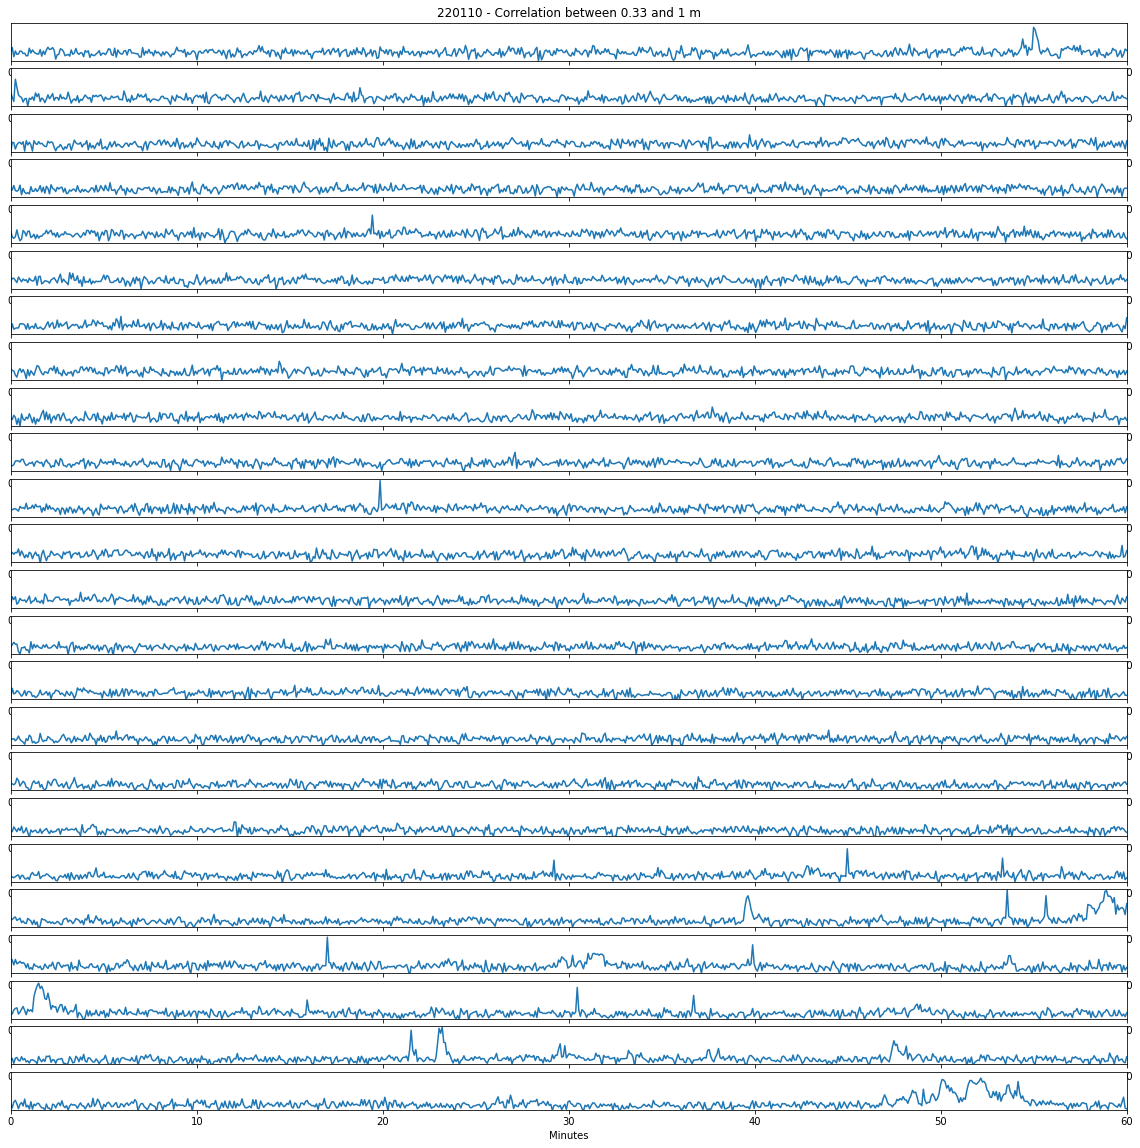

In [72]:
correlation_plot(r, '220110', 0.33, 1, fc = 1, wind_len_sec = 5, in_dir = in_dir)

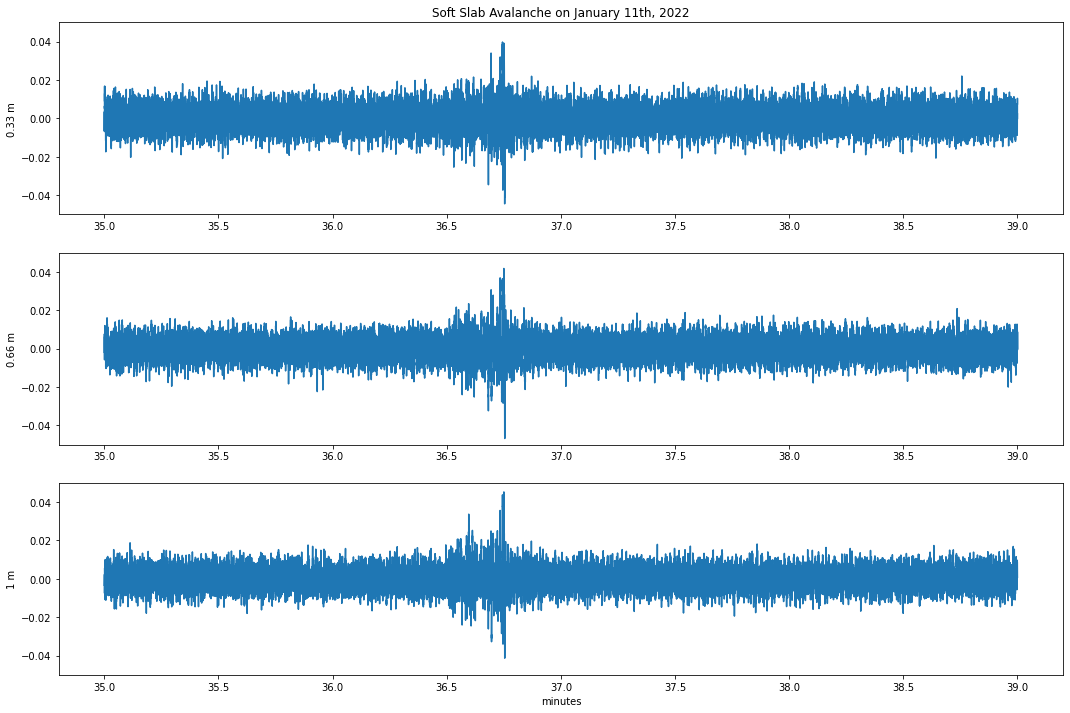

In [71]:
show_eq_all_heights(day_list = r, eq_day = '220111', eq_hour = 1, start_min = 35, end_min = 39, fc_low = 1, title= 'Soft Slab Avalanche on January 11th, 2022', ylims=(-0.05,0.05))

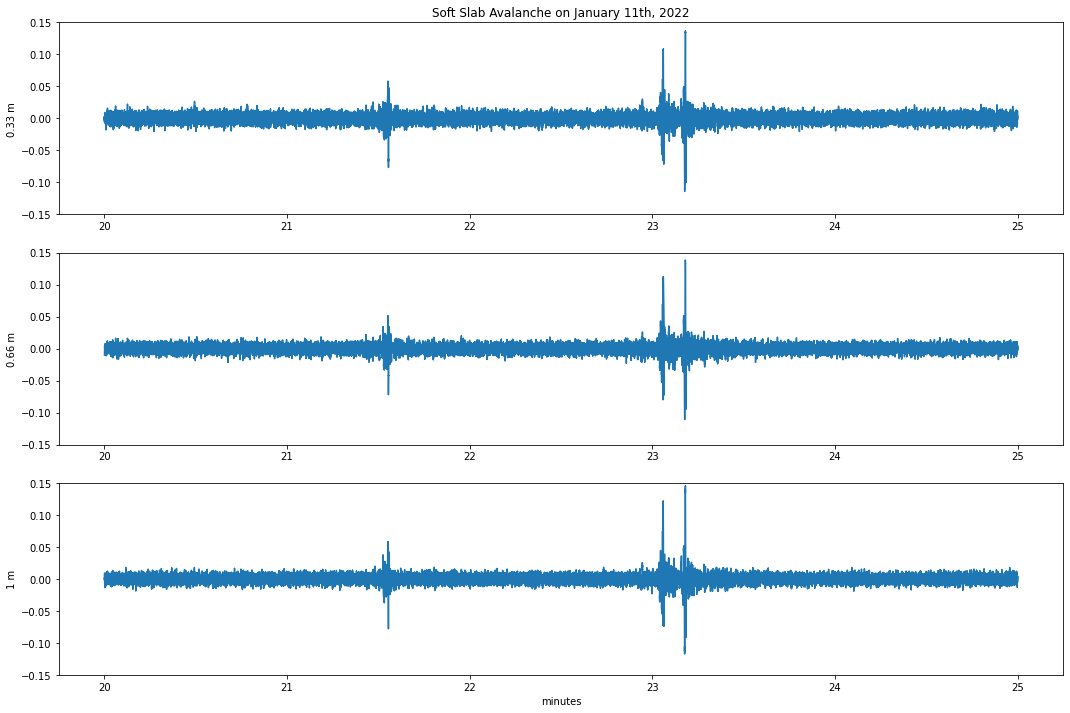

In [77]:
show_eq_all_heights(day_list = r, eq_day = '220110', eq_hour = 22, start_min = 20, end_min = 25, fc_low = 1, title= 'Soft Slab Avalanche on January 11th, 2022', ylims=(-0.15,0.15))

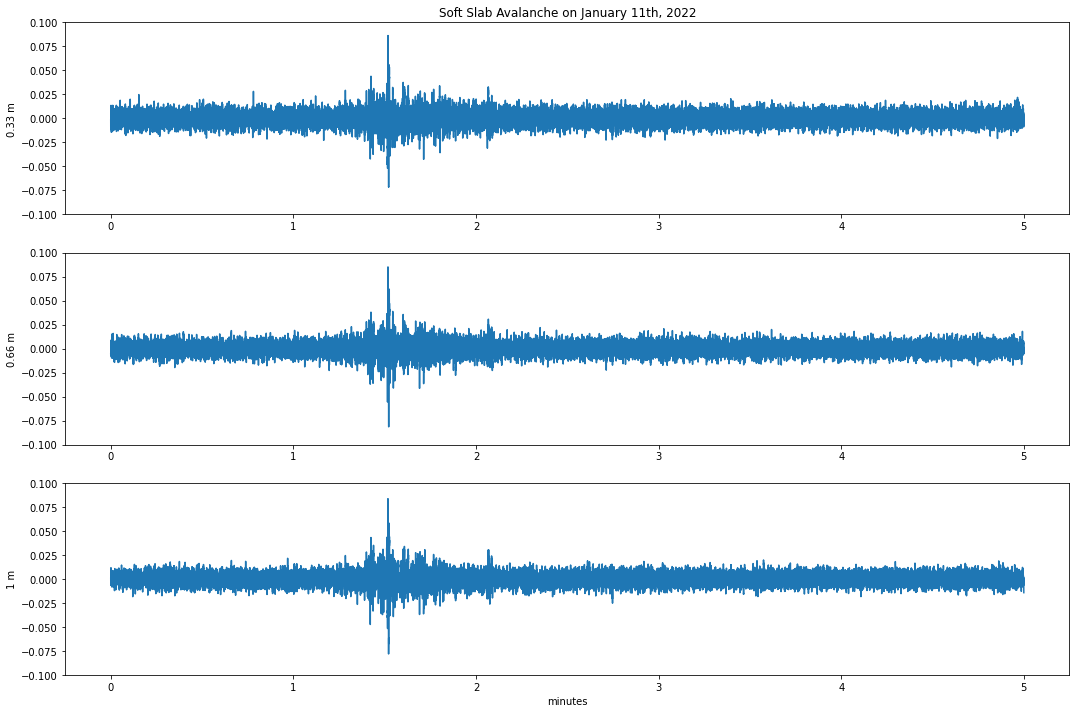

In [79]:
show_eq_all_heights(day_list = r, eq_day = '220110', eq_hour = 21, start_min = 0, end_min = 5, fc_low = 1, title= 'Soft Slab Avalanche on January 11th, 2022', ylims=(-0.1,0.1))

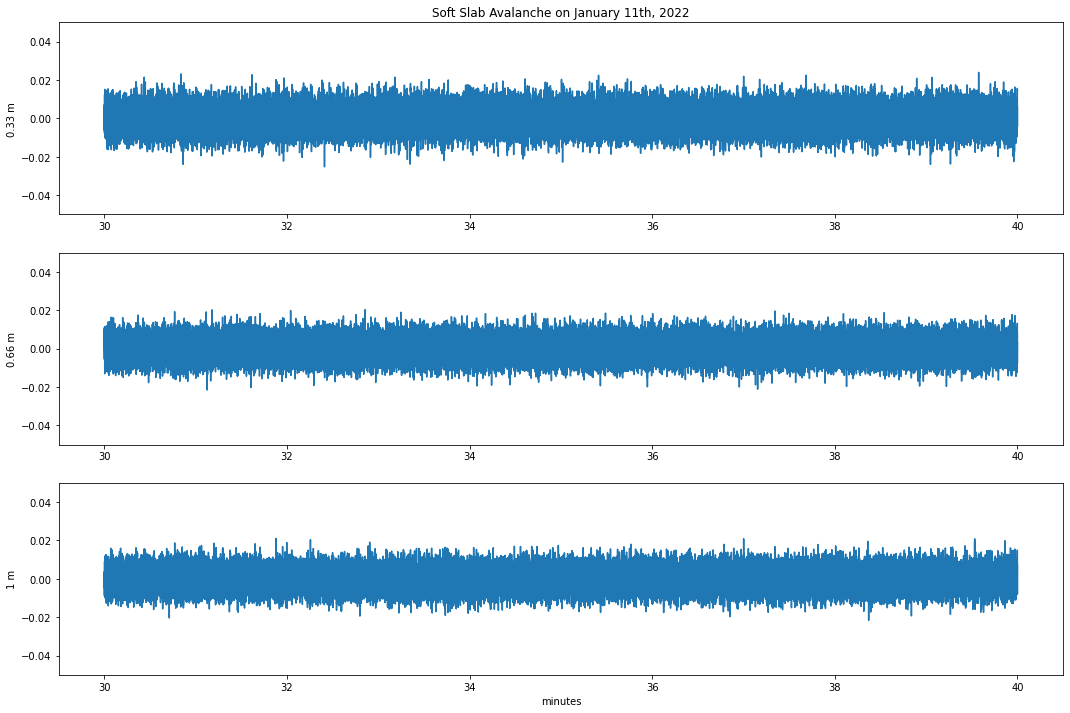

In [85]:
show_eq_all_heights(day_list = r, eq_day = '220110', eq_hour = 15, start_min = 30, end_min = 40, fc_low = 1, title= 'Soft Slab Avalanche on January 11th, 2022', ylims=(-0.05,0.05))

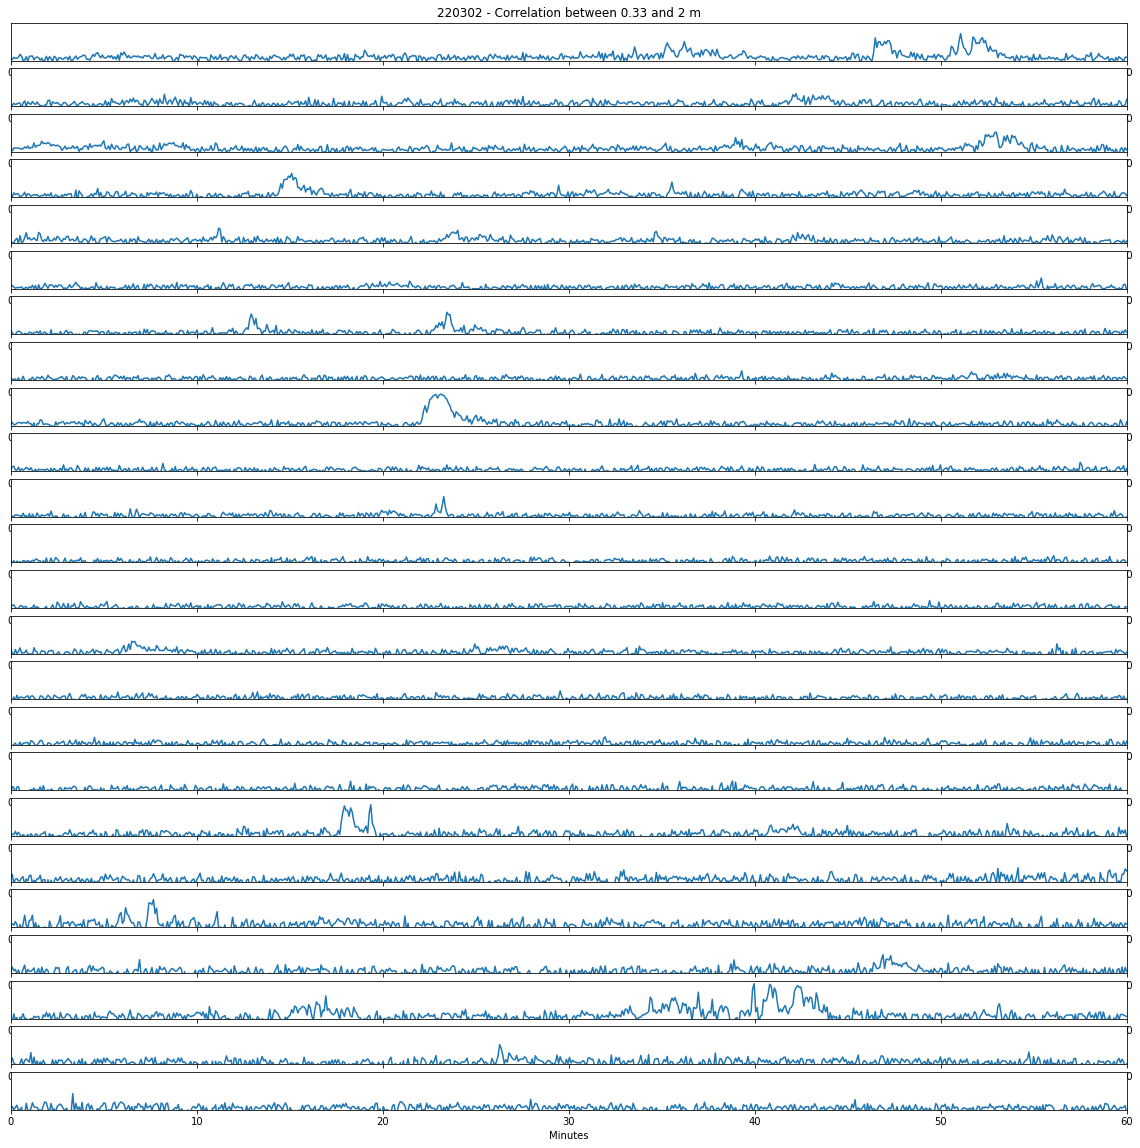

In [86]:
correlation_plot(r, '220302', 0.33, 2, fc = 1, wind_len_sec = 5, in_dir = in_dir)

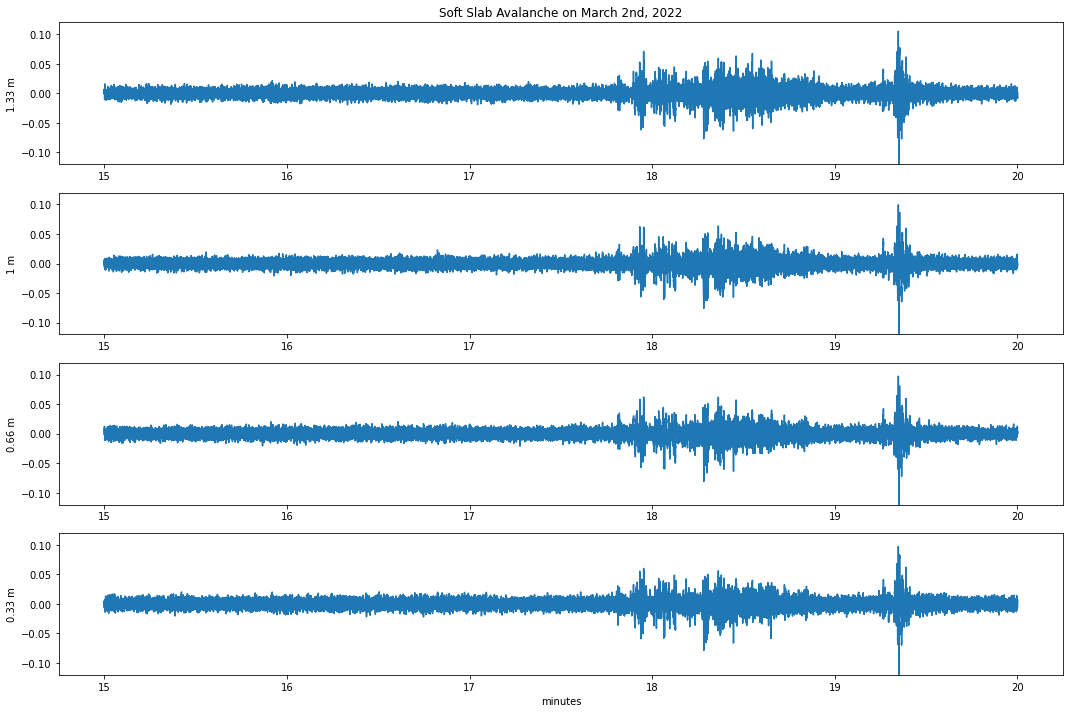

In [89]:
show_eq_all_heights(day_list = r, eq_day = '220302', eq_hour = 17, start_min = 15, end_min = 20, fc_low = 1, title= 'Soft Slab Avalanche on March 2nd, 2022', ylims=(-0.12,0.12))

In [36]:
tz = pd.to_datetime('2022-02-10T03:05').tz_localize('UTC')
tz.tz_convert(tz = 'America/Boise')

Timestamp('2022-02-09 20:05:00-0700', tz='America/Boise')